# Comparing Molecules among Molecular Libraries

In [1]:
import pickle
import pandas as pd
import numpy as np
from rdkit import Chem
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('..')
sns.set(style='white', context='talk', font_scale=0.9)

RDKit WARNING: [12:47:34] Enabling RDKit 2019.09.1 jupyter extensions


#### Load the data

In [2]:
# Import the dictionary of dataframes with the rdkit molecules
file_rd_mols = './fxa_rdkit_db_molecules.obj'
with open(file_rd_mols, 'rb') as f:
    lig_datasets = pickle.load(f)

In [3]:
print(lig_datasets.keys())
print('\n' + '-'* 50 + '\nExample:')
lig_datasets['COCRYS'].head(3)

dict_keys(['COCRYS', 'DUD', 'DEKOIS'])

--------------------------------------------------
Example:


,Activity,mol_rdk,sanitized
Lig,,,
RPR,active,<rdkit.Chem.rdchem.Mol object at 0x7effef3a98f0>,False
815,active,<rdkit.Chem.rdchem.Mol object at 0x7effef3a9930>,True
PR2,active,<rdkit.Chem.rdchem.Mol object at 0x7effef3a9970>,True


## Using RDKit to evaluate some molecular descriptors
##### The following function computes some features like Molecular Mass, number of heavy atoms, number of rotamers and number of rings.

In [4]:
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors
from rdkit.Chem.rdmolops import FastFindRings

# Get the molecular weight and # of heavy atoms for each ligand
for dataset in lig_datasets.values():
    # molecular weight
    dataset['MW'] = [round(Descriptors.MolWt(m), 3) for m in dataset['mol_rdk']]
    # number of heavy atoms
    dataset['num_atoms'] = [round(Chem.Lipinski.HeavyAtomCount(m), 3) for m in dataset['mol_rdk']]
    # Update ring properties
    mol_update = [FastFindRings(m) for m in dataset['mol_rdk']]
    # Get number of rotamers
    dataset['num_rot'] = [round(Chem.Lipinski.NumRotatableBonds(m), 3) for m in dataset['mol_rdk']]
    # Get number of rings
    dataset['num_rings'] = [round(rdMolDescriptors.CalcNumRings(m), 3) for m in dataset['mol_rdk']]

### Plots

In [5]:
# Import some helper functions
from helper_functions_2 import violin_plot_helper, swarm_plot_helper

In [6]:
# Declare a color palette
# palette = ['#2F9C53', '#FBB300', '#9166DC', '#F55036']
# swarm_plot_helper('MW', lig_datasets,
  #                 title = 'Molecular Mass of the four libraries', palette= palette,
  #                 xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split=False, size=2.7)
# too many points!! let's use a violin plot instead..

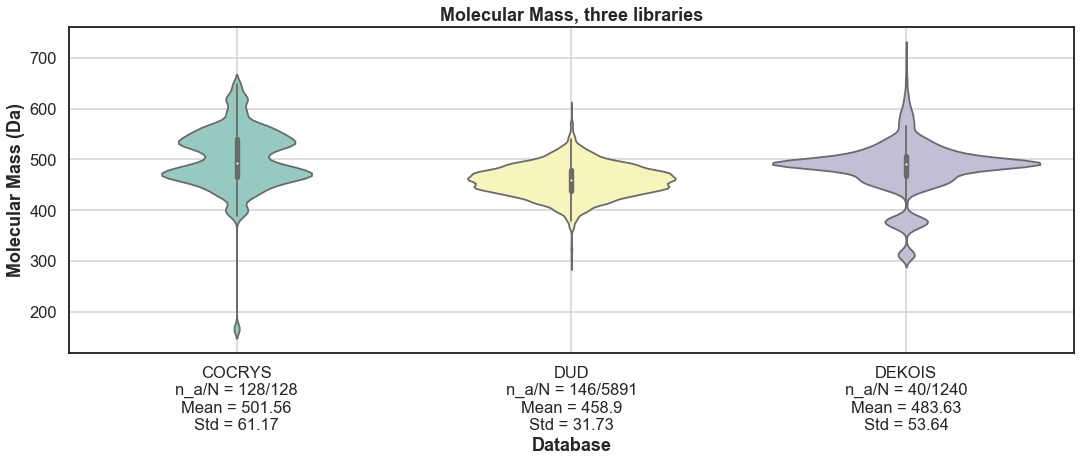

In [7]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass, three libraries', palette= 'Set3',
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=False, )

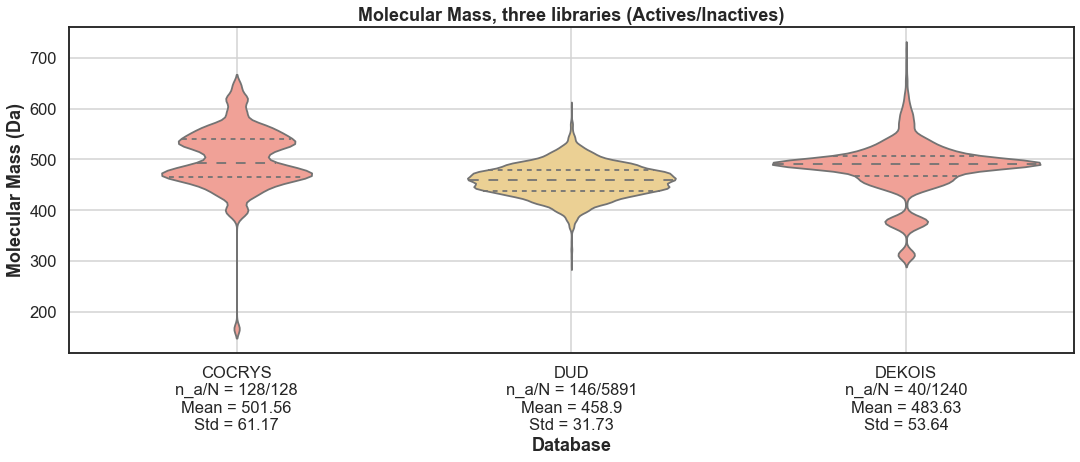

In [8]:
violin_plot_helper('MW', lig_datasets,
                   title = 'Molecular Mass, three libraries (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Molecular Mass (Da)', split_by_activity=True)

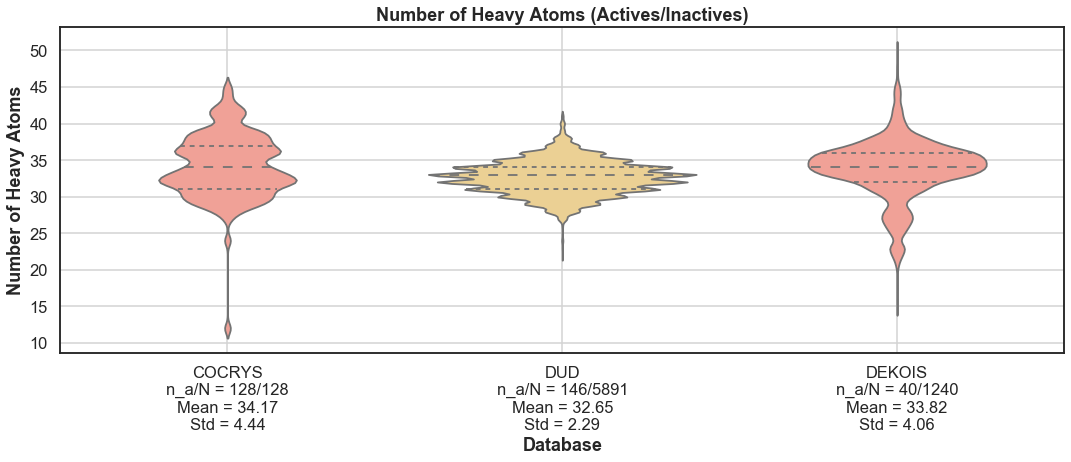

In [9]:
violin_plot_helper('num_atoms', lig_datasets,
                   title = 'Number of Heavy Atoms (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'], inner="quartile",
                   xlabel= 'Database', ylabel = 'Number of Heavy Atoms', split_by_activity=True)

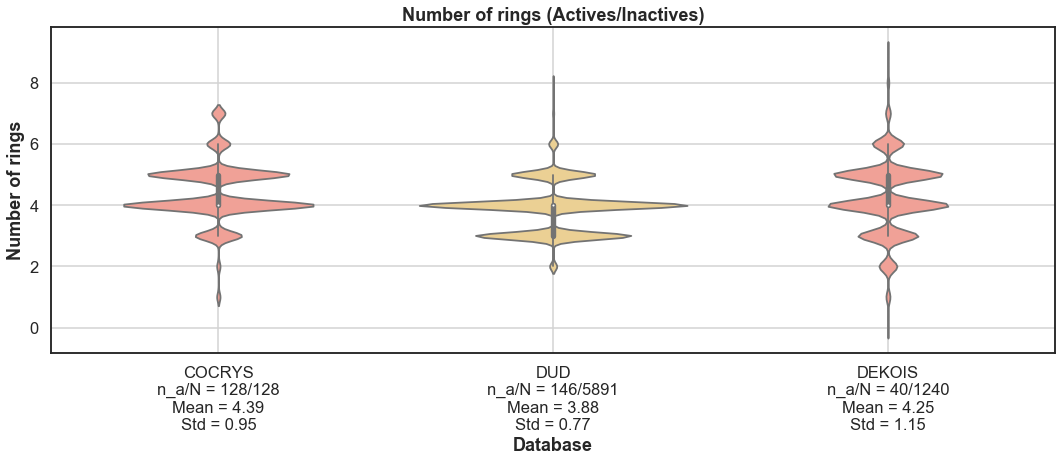

In [10]:
violin_plot_helper('num_rings', lig_datasets,
                   title = 'Number of rings (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'],
                   xlabel= 'Database', ylabel = 'Number of rings', split_by_activity=True)

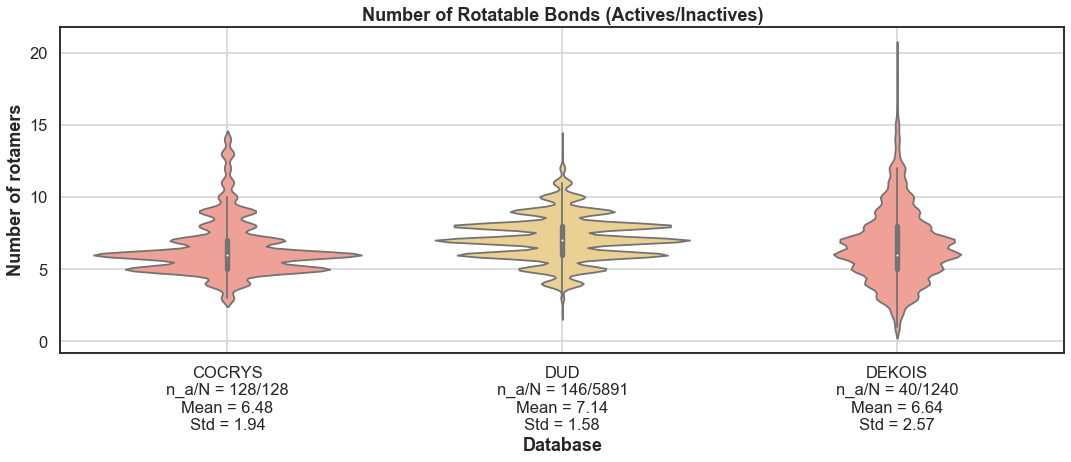

In [11]:
violin_plot_helper('num_rot', lig_datasets,
                   title = 'Number of Rotatable Bonds (Actives/Inactives)',
                   palette=['#FF9588', '#FAD585'],
                   xlabel= 'Database', ylabel = 'Number of rotamers', split_by_activity=True)

### Fingerprints

In [12]:
from rdkit.Chem import MACCSkeys

for dataset in lig_datasets.values():
    # MACCS Keys Fingetprints
    dataset['fps_maccs'] = [MACCSkeys.GenMACCSKeys(i) for i in dataset['mol_rdk']]

In [13]:
lig_datasets['COCRYS'][['fps_maccs']].loc['815', :]

fps_maccs    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 815, dtype: object

In [14]:
for dataset in lig_datasets.values():
    # RDKit Fingetprints
    dataset['fps_rdk'] = [Chem.RDKFingerprint(i, fpSize=2048, minPath=1, maxPath=7)
                          for i in dataset['mol_rdk']]

In [15]:
from helper_functions_2 import draw_matched_ligs, compare_lig_db

In [16]:
%%time
matched_ligands = compare_lig_db('fps_maccs', lig_datasets, method = 'tanimoto')


COCRYS 	 DUD
PR2 	 ligand_19
XLC 	 ligand_21
RRR 	 ligand_3
RDR 	 ligand_20
M35 	 ligand_26

COCRYS 	 DEKOIS
GSV 	 ligand_13

DUD 	 DEKOIS
ligand_10 	 ligand_4
ligand_28 	 ligand_15
ligand_53 	 ligand_40
decoy_1778 	 decoy_797
decoy_3987 	 decoy_449
decoy_3988 	 decoy_449
CPU times: user 2min 46s, sys: 125 ms, total: 2min 46s
Wall time: 2min 46s


=========================     DUD-DEKOIS     =========================


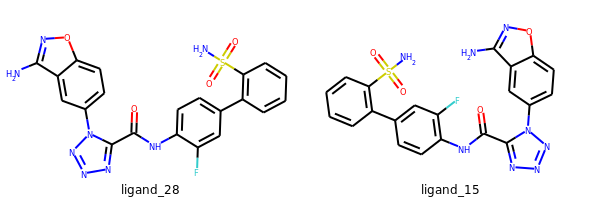

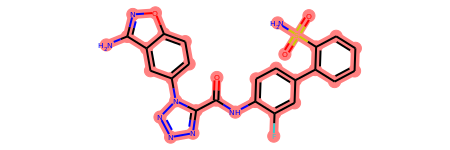

=========================     DUD-DEKOIS     =========================


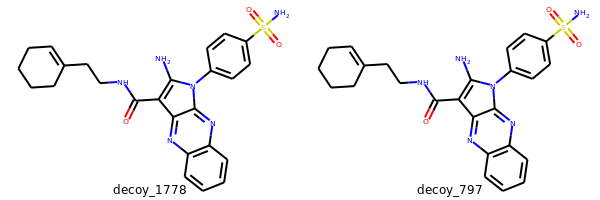

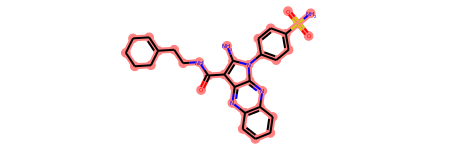

In [17]:
draw_matched_ligs('DUD-DEKOIS', matched_ligands)